In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text, desc

In [4]:
def print_tables():
    # Display the tables and their columns
    inspector = inspect(engine)
    tables = inspector.get_table_names()

    for table in tables:
        print(f'For table: {table}')
        columns = inspector.get_columns(table)
        for column in columns:
            print(column['name'], column['type'])
        print()

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
print_tables()

For table: measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

For table: station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



# Exploratory Precipitation Analysis

In [10]:
# Read the query
measurement = session.query(Measurement)

# Find the most recent date in the data set.
recent = measurement.order_by(Measurement.date.desc()).first()
print(f'Most recent date in dataset: {recent.date}')


Most recent date in dataset: 2017-08-23


The last 12 months of data are 2016-08-23 through 2017-08-23


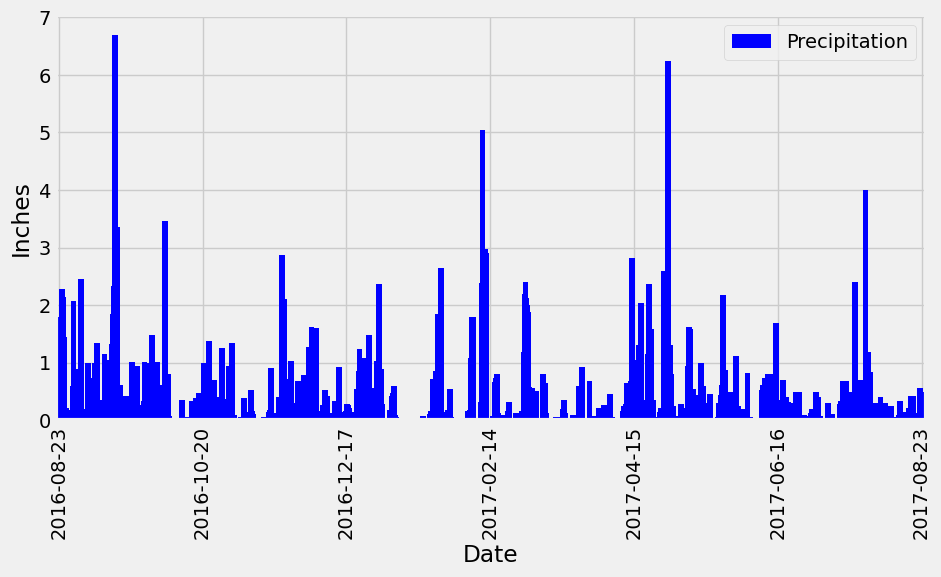

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = pd.to_datetime(recent.date)

# Calculate the date one year from the last date in data set.
prev_year = recent_date - relativedelta(years=1)

recent_date = recent_date.strftime('%Y-%m-%d')
prev_year = prev_year.strftime('%Y-%m-%d')
print(f'The last 12 months of data are {prev_year} through {recent_date}')

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,
                        Measurement.prcp).\
    filter(Measurement.date >= prev_year,
           Measurement.date <= recent_date).\
        order_by(Measurement.date).all()
        
       
# # Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results)

# Rename 'prcp' to 'Percipitation'        
df.rename(columns={'prcp': 'Precipitation'}, inplace=True) 
# print(df)

# Sort the dataframe by date
# All ready done with the 'order_by()'

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(
        x='date', 
        y='Precipitation', 
        kind='bar', 
        width=15,
        figsize=(10, 5), 
        color='blue', 
        legend=True)
# plt.title('Precipitation in Last 12 Months of Data')
plt.xlabel('Date')
plt.ylabel('Inches')

# Set the x-ticks to show only 6 evenly spaced ticks
num_ticks = 6
ax.set_xticks(range(0, len(df), max(1, len(df) // num_ticks)))
ax.set_xticklabels(df['date'][::max(1, len(df) // num_ticks)], rotation=90)
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
df['Precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station = session.query(Station)
print(f'There are {station.count()} stations in the dataset')

There are 9 stations in the dataset


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(
    Measurement.station,
    func.count(Measurement.station).label('count')).\
        group_by(Measurement.station).order_by(desc('count')).all()
        
station_counts_df = pd.DataFrame(station_counts, columns=['station_id', 'count'])

print(station_counts_df)

    station_id  count
0  USC00519281   2772
1  USC00519397   2724
2  USC00513117   2709
3  USC00519523   2669
4  USC00516128   2612
5  USC00514830   2202
6  USC00511918   1979
7  USC00517948   1372
8  USC00518838    511


In [15]:
# Isolate the name of the most active station
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).first()
        
most_active_station_id = most_active_station[0]

print(f'The most active station is {most_active_station_id}')

The most active station is USC00519281


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_results = session.query(
    func.min(Measurement.tobs).label('lowest'),
    func.max(Measurement.tobs).label('highest'),
    func.avg(Measurement.tobs).label('average')).filter(Measurement.station == most_active_station_id).all()
results = temp_results[0]
print(f'Station {most_active_station_id}:')
print(f'lowest temperature: {results.lowest}F')
print(f'highest temperature: {results.highest}F')
print(f'average temperature: {results.average:.1f}F')

Station USC00519281:
lowest temperature: 54.0F
highest temperature: 85.0F
average temperature: 71.7F


The last 12 months of data are 2016-08-18 through 2017-08-18 for USC00519281


<Axes: xlabel='Temperature', ylabel='Frequency'>

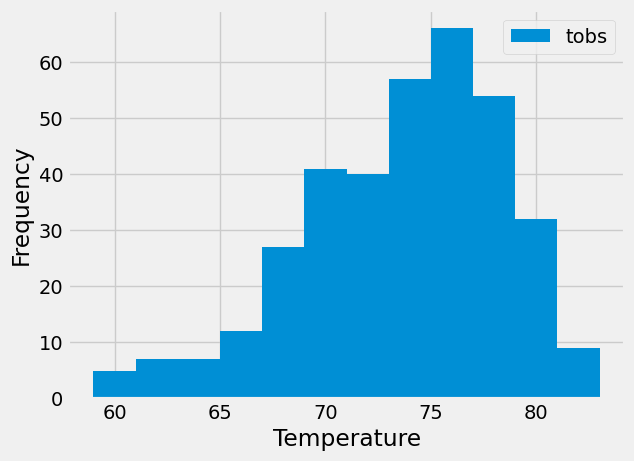

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date = df['date'].max()
recent_date = pd.to_datetime(most_recent_date)

prev_year = recent_date - relativedelta(years=1)

recent_date = recent_date.strftime('%Y-%m-%d')
prev_year = prev_year.strftime('%Y-%m-%d')

print(f'The last 12 months of data are {prev_year} through {recent_date} for {most_active_station_id}')

results = session.query(
        Measurement.date, 
        Measurement.station, 
        Measurement.tobs).filter(Measurement.date >= prev_year,
                                 Measurement.date <= recent_date,
                                 Measurement.station == most_active_station_id).\
                                         order_by(Measurement.date).all()

df = pd.DataFrame(results)

df.plot(x='date', 
        y='tobs', 
        kind='hist', 
        bins=12, 
        xlabel='Temperature', 
        ylabel='Frequency')
                     


# Close Session

In [ ]:
# Close Session
session.close()